<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/crnn/CRNN_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Config

In [2]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI/English_Mandarin"

aug = True

if aug:
    train_set_folders = [
    ]

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"

## Imports and Colab Mount

In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Utility Function Definitions

train_data_components = []
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.ImageFolder(root=os.path.join(folder_path), transform=data_transform))
  train_data = ConcatDataset(train_data_components)

In [5]:
# can also load in data as numpy arrays directly 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(128)])
  test_data = torchvision.datasets.ImageFolder(root=os.path.join(raw_dataset_path,'test'), transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root=os.path.join(raw_dataset_path,'validation'), transform=data_transform)

  train_data_components = [torchvision.datasets.ImageFolder(root=os.path.join(raw_dataset_path,'train'), transform=data_transform)]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.ImageFolder(root=os.path.join(folder_path), transform=data_transform))
  train_data = ConcatDataset(train_data_components)

  return train_data, val_data, test_data

def visualize_image_data(dataset, classes):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])
  return(images.shape)

def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  raw_train_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "train"), loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "validation"), loader=numpy_loader,extensions='.npy',transform=data_transform)

  train_data_components = [raw_train_data]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.DatasetFolder(root=folder_path, loader=numpy_loader,extensions='.npy',transform=data_transform))
  train_data = ConcatDataset(train_data_components)
  return raw_train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy_cnn(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda().float()
          labels = labels.cuda()
        out = model(imgs.float()) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## Base Arch

In [26]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 32, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

## Data Gen

Array shape is (27, 1, 13, 431)
13


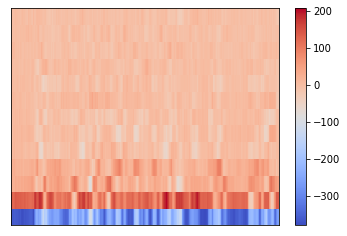

In [ ]:
train_data, val_data, []= generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
print(mfcc_bands)

In [ ]:
from collections import Counter

print(dict(Counter(train_data.targets)))
train_data.classes

{0: 126, 1: 184}


['english', 'mandarin']

## Train Func

In [27]:
def train_crnn_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    best_val_acc = 0 
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.float().cuda()
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_cnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        if epoch>30 and val_acc[-1]>best_val_acc:
            print("SAVED MODEL")
            model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
            checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, str(epoch+1))
            full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
            try:
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
            except FileNotFoundError:
                os.makedirs(full_checkpoint_path)
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        if val_acc[-1]>best_val_acc:
            best_val_acc = val_acc[-1]
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

## CRNN Binary with MFCC

Dataset: raw_10s_3classes_npy

Augmentation: None

Architecture: 2 conv layer (16,32 output, 3 kernel), 50 hidden units, 3 linear layers ( 20 -> 10, 10 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50

Using CUDA
Epoch:  0 Train Accuracy:  0.569023569023569 Val Accuracy:  0.5740740740740741 Progress:   2.00  % Time Elapsed:   2.51 s 
Epoch 0 Finished.  Time per Epoch:   2.51 s 
Epoch:  1 Train Accuracy:  0.6734006734006734 Val Accuracy:  0.6111111111111112 Progress:   4.00  % Time Elapsed:   4.99 s 
Epoch 1 Finished.  Time per Epoch:   2.50 s 
Epoch:  2 Train Accuracy:  0.7272727272727273 Val Accuracy:  0.6851851851851852 Progress:   6.00  % Time Elapsed:   7.52 s 
Epoch 2 Finished.  Time per Epoch:   2.51 s 
Epoch:  3 Train Accuracy:  0.7306397306397306 Val Accuracy:  0.6666666666666666 Progress:   8.00  % Time Elapsed:  10.01 s 
Epoch 3 Finished.  Time per Epoch:   2.50 s 
Epoch:  4 Train Accuracy:  0.7744107744107744 Val Accuracy:  0.7407407407407407 Progress:  10.00  % Time Elapsed:  12.50 s 
Epoch 4 Finished.  Time per Epoch:   2.50 s 
Epoch:  5 Train Accuracy:  0.8080808080808081 Val Accuracy:  0.6296296296296297 Progress:  12.00  % Time Elapsed:  14.99 s 
Epoch 5 Finished.  Ti

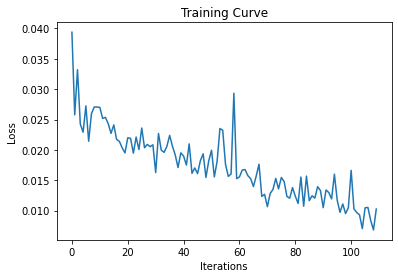

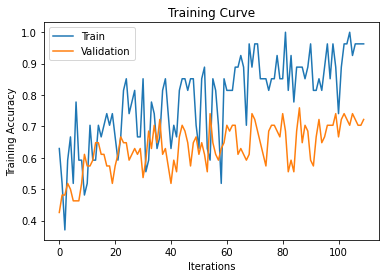

Epoch:  10 Train Accuracy:  0.9259259259259259 Val Accuracy:  0.5740740740740741 Progress:  22.00  % Time Elapsed:  27.85 s 
Epoch 10 Finished.  Time per Epoch:   2.53 s 
Epoch:  11 Train Accuracy:  0.8855218855218855 Val Accuracy:  0.6296296296296297 Progress:  24.00  % Time Elapsed:  30.35 s 
Epoch 11 Finished.  Time per Epoch:   2.53 s 
Epoch:  12 Train Accuracy:  0.9461279461279462 Val Accuracy:  0.7407407407407407 Progress:  26.00  % Time Elapsed:  32.88 s 
Epoch 12 Finished.  Time per Epoch:   2.53 s 
Epoch:  13 Train Accuracy:  0.9764309764309764 Val Accuracy:  0.7592592592592593 Progress:  28.00  % Time Elapsed:  35.40 s 
Epoch 13 Finished.  Time per Epoch:   2.53 s 
Epoch:  14 Train Accuracy:  0.9663299663299664 Val Accuracy:  0.7222222222222222 Progress:  30.00  % Time Elapsed:  37.88 s 
Epoch 14 Finished.  Time per Epoch:   2.53 s 
Epoch:  15 Train Accuracy:  0.9663299663299664 Val Accuracy:  0.7777777777777778 Progress:  32.00  % Time Elapsed:  40.40 s 
Epoch 15 Finished.  

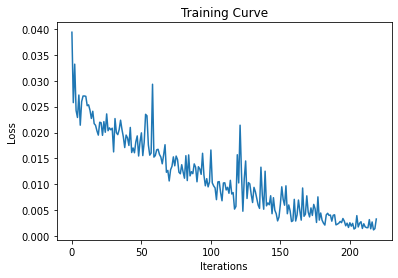

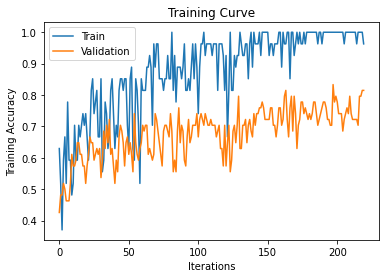

Epoch:  20 Train Accuracy:  1.0 Val Accuracy:  0.7222222222222222 Progress:  42.00  % Time Elapsed:  53.20 s 
Epoch 20 Finished.  Time per Epoch:   2.53 s 
Epoch:  21 Train Accuracy:  0.9966329966329966 Val Accuracy:  0.7592592592592593 Progress:  44.00  % Time Elapsed:  55.72 s 
Epoch 21 Finished.  Time per Epoch:   2.53 s 
Epoch:  22 Train Accuracy:  1.0 Val Accuracy:  0.8148148148148148 Progress:  46.00  % Time Elapsed:  58.24 s 
Epoch 22 Finished.  Time per Epoch:   2.53 s 
Epoch:  23 Train Accuracy:  0.9966329966329966 Val Accuracy:  0.6296296296296297 Progress:  48.00  % Time Elapsed:  60.78 s 
Epoch 23 Finished.  Time per Epoch:   2.53 s 
Epoch:  24 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  50.00  % Time Elapsed:  63.29 s 
Epoch 24 Finished.  Time per Epoch:   2.53 s 
Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  52.00  % Time Elapsed:  65.77 s 
Epoch 25 Finished.  Time per Epoch:   2.53 s 
Epoch:  26 Train Accuracy:  1.0 Va

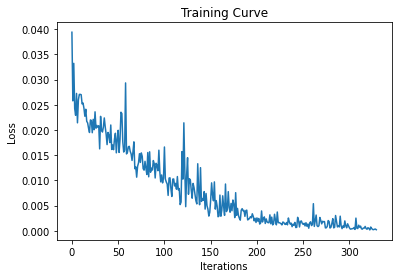

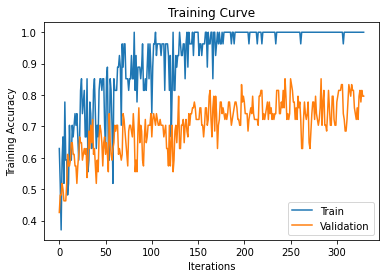

Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  62.00  % Time Elapsed:  78.65 s 
Epoch 30 Finished.  Time per Epoch:   2.54 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.7592592592592593 Progress:  64.00  % Time Elapsed:  81.31 s 
Epoch 31 Finished.  Time per Epoch:   2.54 s 
Epoch:  32 Train Accuracy:  1.0 Val Accuracy:  0.7592592592592593 Progress:  66.00  % Time Elapsed:  84.01 s 
Epoch 32 Finished.  Time per Epoch:   2.55 s 
Epoch:  33 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  68.00  % Time Elapsed:  86.72 s 
Epoch 33 Finished.  Time per Epoch:   2.55 s 
Epoch:  34 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  70.00  % Time Elapsed:  89.38 s 
Epoch 34 Finished.  Time per Epoch:   2.55 s 
Epoch:  35 Train Accuracy:  1.0 Val Accuracy:  0.7592592592592593 Progress:  72.00  % Time Elapsed:  91.86 s 
Epoch 35 Finished.  Time per Epoch:   2.55 s 
Epoch:  36 Train Accuracy:  1.0 Val Accuracy:  0.759259259259259

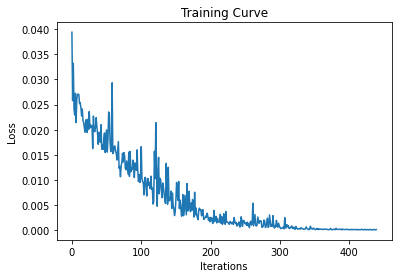

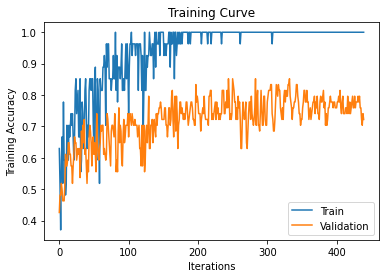

Epoch:  40 Train Accuracy:  1.0 Val Accuracy:  0.7592592592592593 Progress:  82.00  % Time Elapsed:  104.70 s 
Epoch 40 Finished.  Time per Epoch:   2.55 s 
Epoch:  41 Train Accuracy:  1.0 Val Accuracy:  0.7962962962962963 Progress:  84.00  % Time Elapsed:  107.17 s 
Epoch 41 Finished.  Time per Epoch:   2.55 s 
Epoch:  42 Train Accuracy:  1.0 Val Accuracy:  0.7592592592592593 Progress:  86.00  % Time Elapsed:  109.67 s 
Epoch 42 Finished.  Time per Epoch:   2.55 s 
Epoch:  43 Train Accuracy:  1.0 Val Accuracy:  0.7592592592592593 Progress:  88.00  % Time Elapsed:  112.16 s 
Epoch 43 Finished.  Time per Epoch:   2.55 s 
Epoch:  44 Train Accuracy:  1.0 Val Accuracy:  0.7592592592592593 Progress:  90.00  % Time Elapsed:  114.63 s 
Epoch 44 Finished.  Time per Epoch:   2.55 s 
Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  92.00  % Time Elapsed:  117.14 s 
Epoch 45 Finished.  Time per Epoch:   2.55 s 
Epoch:  46 Train Accuracy:  1.0 Val Accuracy:  0.759259259

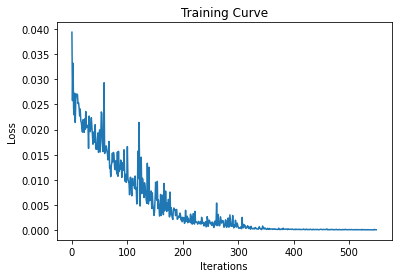

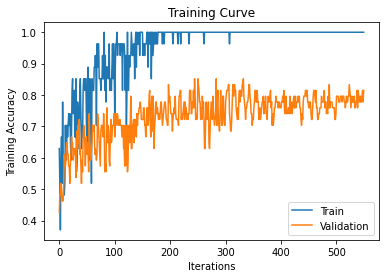

Finished Training
Total time:   127.37 s  Time per Epoch:   2.55 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Mandarin",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

In [ ]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI/English_Mandarin"

aug = True

if aug:
    train_set_folders = [
    ]

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"

Array shape is (27, 1, 13, 431)
13


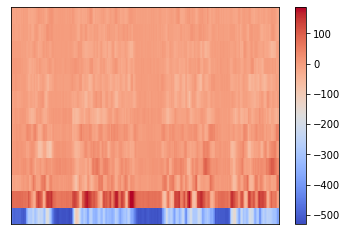

In [ ]:
train_data, val_data, []= generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
print(mfcc_bands)

Using CUDA
Epoch:  0 Train Accuracy:  0.5286195286195287 Val Accuracy:  0.5370370370370371 Progress:   2.00  % Time Elapsed:   2.61 s 
Epoch 0 Finished.  Time per Epoch:   2.61 s 
Epoch:  1 Train Accuracy:  0.5959595959595959 Val Accuracy:  0.5370370370370371 Progress:   4.00  % Time Elapsed:   5.17 s 
Epoch 1 Finished.  Time per Epoch:   2.59 s 
Epoch:  2 Train Accuracy:  0.6464646464646465 Val Accuracy:  0.6296296296296297 Progress:   6.00  % Time Elapsed:   7.77 s 
Epoch 2 Finished.  Time per Epoch:   2.59 s 
Epoch:  3 Train Accuracy:  0.7037037037037037 Val Accuracy:  0.6111111111111112 Progress:   8.00  % Time Elapsed:  10.36 s 
Epoch 3 Finished.  Time per Epoch:   2.59 s 
Epoch:  4 Train Accuracy:  0.734006734006734 Val Accuracy:  0.6666666666666666 Progress:  10.00  % Time Elapsed:  13.01 s 
Epoch 4 Finished.  Time per Epoch:   2.60 s 
Epoch:  5 Train Accuracy:  0.7441077441077442 Val Accuracy:  0.5740740740740741 Progress:  12.00  % Time Elapsed:  15.63 s 
Epoch 5 Finished.  Ti

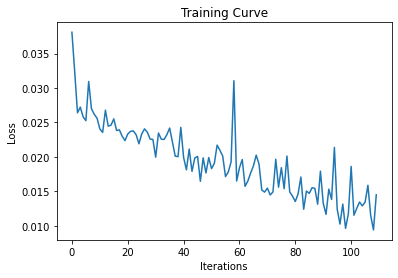

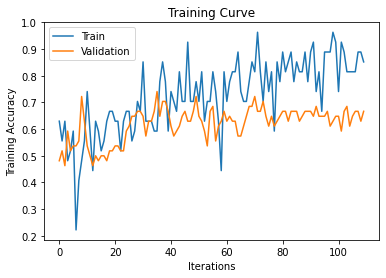

Epoch:  10 Train Accuracy:  0.8383838383838383 Val Accuracy:  0.6111111111111112 Progress:  22.00  % Time Elapsed:  28.97 s 
Epoch 10 Finished.  Time per Epoch:   2.63 s 
Epoch:  11 Train Accuracy:  0.8754208754208754 Val Accuracy:  0.6666666666666666 Progress:  24.00  % Time Elapsed:  31.58 s 
Epoch 11 Finished.  Time per Epoch:   2.63 s 
Epoch:  12 Train Accuracy:  0.8855218855218855 Val Accuracy:  0.6666666666666666 Progress:  26.00  % Time Elapsed:  34.16 s 
Epoch 12 Finished.  Time per Epoch:   2.63 s 
Epoch:  13 Train Accuracy:  0.9326599326599326 Val Accuracy:  0.6666666666666666 Progress:  28.00  % Time Elapsed:  36.80 s 
Epoch 13 Finished.  Time per Epoch:   2.63 s 
Epoch:  14 Train Accuracy:  0.936026936026936 Val Accuracy:  0.7037037037037037 Progress:  30.00  % Time Elapsed:  39.37 s 
Epoch 14 Finished.  Time per Epoch:   2.62 s 
Epoch:  15 Train Accuracy:  0.9259259259259259 Val Accuracy:  0.6666666666666666 Progress:  32.00  % Time Elapsed:  41.94 s 
Epoch 15 Finished.  T

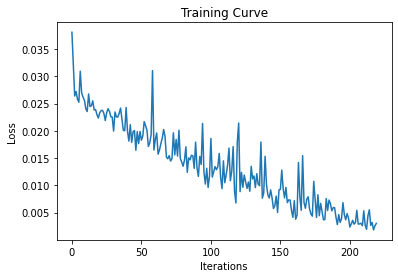

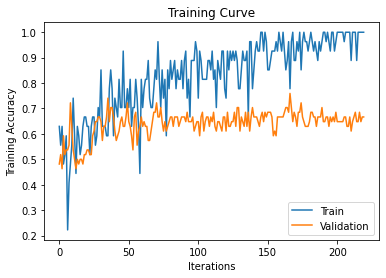

Epoch:  20 Train Accuracy:  0.9966329966329966 Val Accuracy:  0.6481481481481481 Progress:  42.00  % Time Elapsed:  55.18 s 
Epoch 20 Finished.  Time per Epoch:   2.63 s 
Epoch:  21 Train Accuracy:  0.9966329966329966 Val Accuracy:  0.6851851851851852 Progress:  44.00  % Time Elapsed:  57.76 s 
Epoch 21 Finished.  Time per Epoch:   2.63 s 
Epoch:  22 Train Accuracy:  0.9966329966329966 Val Accuracy:  0.7037037037037037 Progress:  46.00  % Time Elapsed:  60.37 s 
Epoch 22 Finished.  Time per Epoch:   2.62 s 
Epoch:  23 Train Accuracy:  0.9966329966329966 Val Accuracy:  0.6851851851851852 Progress:  48.00  % Time Elapsed:  62.96 s 
Epoch 23 Finished.  Time per Epoch:   2.62 s 
Epoch:  24 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  50.00  % Time Elapsed:  65.53 s 
Epoch 24 Finished.  Time per Epoch:   2.62 s 
Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  52.00  % Time Elapsed:  68.12 s 
Epoch 25 Finished.  Time per Epoch:   2.62 s 
Epoc

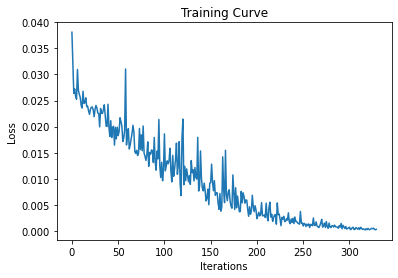

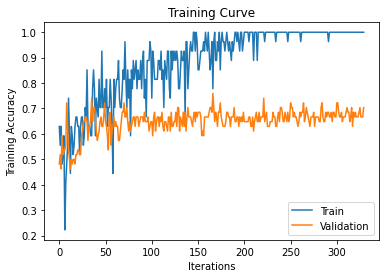

Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  62.00  % Time Elapsed:  81.39 s 
Epoch 30 Finished.  Time per Epoch:   2.63 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  64.00  % Time Elapsed:  83.97 s 
Epoch 31 Finished.  Time per Epoch:   2.62 s 
Epoch:  32 Train Accuracy:  1.0 Val Accuracy:  0.7222222222222222 Progress:  66.00  % Time Elapsed:  86.60 s 
Epoch 32 Finished.  Time per Epoch:   2.62 s 
SAVED MODEL
Epoch:  33 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  68.00  % Time Elapsed:  89.20 s 
Epoch 33 Finished.  Time per Epoch:   2.62 s 
Epoch:  34 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  70.00  % Time Elapsed:  91.79 s 
Epoch 34 Finished.  Time per Epoch:   2.62 s 
Epoch:  35 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  72.00  % Time Elapsed:  94.42 s 
Epoch 35 Finished.  Time per Epoch:   2.62 s 
Epoch:  36 Train Accuracy:  1.0 Val Accuracy:  0.648

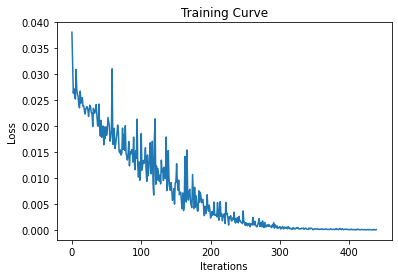

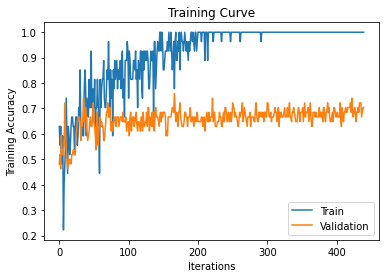

Epoch:  40 Train Accuracy:  1.0 Val Accuracy:  0.7222222222222222 Progress:  82.00  % Time Elapsed:  107.79 s 
Epoch 40 Finished.  Time per Epoch:   2.63 s 
Epoch:  41 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  84.00  % Time Elapsed:  110.37 s 
Epoch 41 Finished.  Time per Epoch:   2.63 s 
Epoch:  42 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  86.00  % Time Elapsed:  112.94 s 
Epoch 42 Finished.  Time per Epoch:   2.63 s 
Epoch:  43 Train Accuracy:  1.0 Val Accuracy:  0.7222222222222222 Progress:  88.00  % Time Elapsed:  115.53 s 
Epoch 43 Finished.  Time per Epoch:   2.63 s 
Epoch:  44 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  90.00  % Time Elapsed:  118.11 s 
Epoch 44 Finished.  Time per Epoch:   2.62 s 
Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  92.00  % Time Elapsed:  120.67 s 
Epoch 45 Finished.  Time per Epoch:   2.62 s 
Epoch:  46 Train Accuracy:  1.0 Val Accuracy:  0.685185185

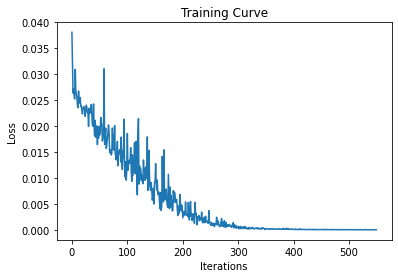

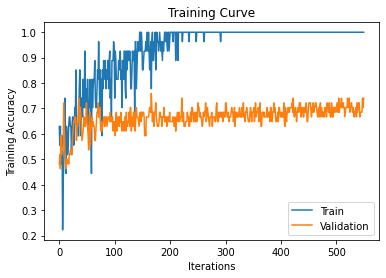

Finished Training
Total time:   131.35 s  Time per Epoch:   2.63 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Indian",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

# CRNN Binary with Mel Spectogram


Array shape is (27, 1, 128, 431)
128


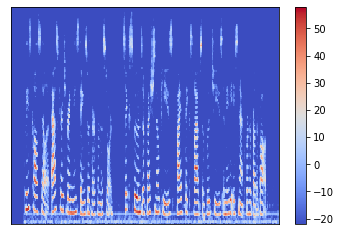

In [28]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI/English_Mandarin_MelSpec"

aug = True

if aug:
    train_set_folders = [
    ]

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"
train_data, val_data, []= generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
print(mfcc_bands)

Using CUDA
Epoch:  0 Train Accuracy:  0.5238095238095238 Val Accuracy:  0.8148148148148148 Progress:   2.00  % Time Elapsed:   2.05 s 
Epoch 0 Finished.  Time per Epoch:   2.05 s 
Epoch:  1 Train Accuracy:  0.6190476190476191 Val Accuracy:  0.7777777777777778 Progress:   4.00  % Time Elapsed:   4.10 s 
Epoch 1 Finished.  Time per Epoch:   2.05 s 
Epoch:  2 Train Accuracy:  0.6878306878306878 Val Accuracy:  0.5925925925925926 Progress:   6.00  % Time Elapsed:   6.19 s 
Epoch 2 Finished.  Time per Epoch:   2.06 s 
Epoch:  3 Train Accuracy:  0.7671957671957672 Val Accuracy:  0.7037037037037037 Progress:   8.00  % Time Elapsed:   8.26 s 
Epoch 3 Finished.  Time per Epoch:   2.07 s 
Epoch:  4 Train Accuracy:  0.798941798941799 Val Accuracy:  0.5925925925925926 Progress:  10.00  % Time Elapsed:  10.35 s 
Epoch 4 Finished.  Time per Epoch:   2.07 s 
Epoch:  5 Train Accuracy:  0.8253968253968254 Val Accuracy:  0.7407407407407407 Progress:  12.00  % Time Elapsed:  12.41 s 
Epoch 5 Finished.  Ti

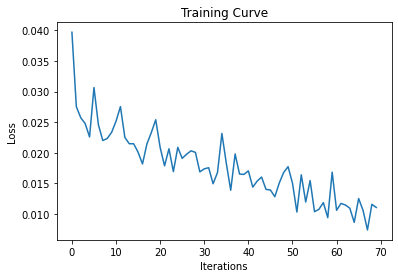

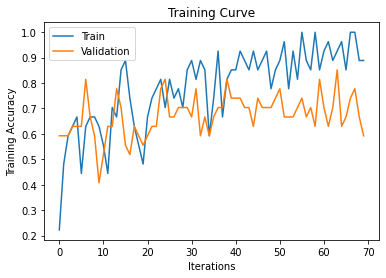

Epoch:  10 Train Accuracy:  0.9470899470899471 Val Accuracy:  0.7777777777777778 Progress:  22.00  % Time Elapsed:  22.94 s 
Epoch 10 Finished.  Time per Epoch:   2.09 s 
Epoch:  11 Train Accuracy:  0.9523809523809523 Val Accuracy:  0.7037037037037037 Progress:  24.00  % Time Elapsed:  24.99 s 
Epoch 11 Finished.  Time per Epoch:   2.08 s 
Epoch:  12 Train Accuracy:  0.9576719576719577 Val Accuracy:  0.7407407407407407 Progress:  26.00  % Time Elapsed:  27.06 s 
Epoch 12 Finished.  Time per Epoch:   2.08 s 
Epoch:  13 Train Accuracy:  0.9417989417989417 Val Accuracy:  0.7777777777777778 Progress:  28.00  % Time Elapsed:  29.15 s 
Epoch 13 Finished.  Time per Epoch:   2.08 s 
Epoch:  14 Train Accuracy:  0.9841269841269841 Val Accuracy:  0.7777777777777778 Progress:  30.00  % Time Elapsed:  31.28 s 
Epoch 14 Finished.  Time per Epoch:   2.09 s 
Epoch:  15 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  32.00  % Time Elapsed:  33.39 s 
Epoch 15 Finished.  Time per Epoch:

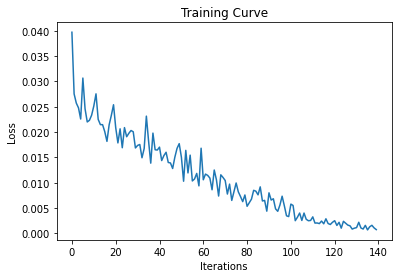

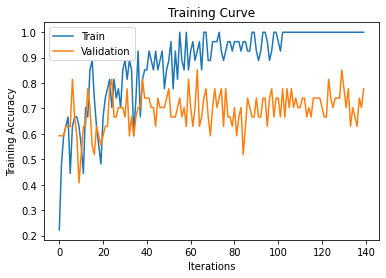

Epoch:  20 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  42.00  % Time Elapsed:  43.98 s 
Epoch 20 Finished.  Time per Epoch:   2.09 s 
Epoch:  21 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  44.00  % Time Elapsed:  46.05 s 
Epoch 21 Finished.  Time per Epoch:   2.09 s 
Epoch:  22 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  46.00  % Time Elapsed:  48.12 s 
Epoch 22 Finished.  Time per Epoch:   2.09 s 
Epoch:  23 Train Accuracy:  1.0 Val Accuracy:  0.6296296296296297 Progress:  48.00  % Time Elapsed:  50.20 s 
Epoch 23 Finished.  Time per Epoch:   2.09 s 
Epoch:  24 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  50.00  % Time Elapsed:  52.28 s 
Epoch 24 Finished.  Time per Epoch:   2.09 s 
Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  52.00  % Time Elapsed:  54.38 s 
Epoch 25 Finished.  Time per Epoch:   2.09 s 
Epoch:  26 Train Accuracy:  1.0 Val Accuracy:  0.740740740740740

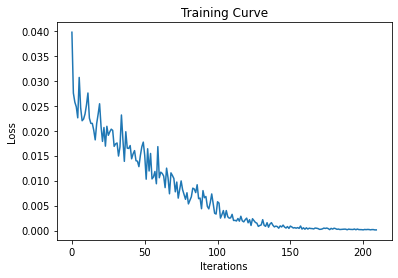

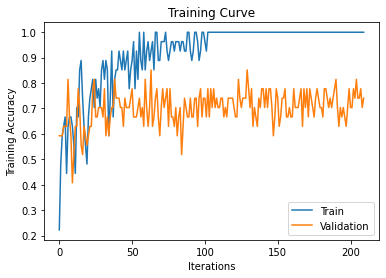

Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  62.00  % Time Elapsed:  65.09 s 
Epoch 30 Finished.  Time per Epoch:   2.10 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  64.00  % Time Elapsed:  67.19 s 
Epoch 31 Finished.  Time per Epoch:   2.10 s 
Epoch:  32 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  66.00  % Time Elapsed:  69.27 s 
Epoch 32 Finished.  Time per Epoch:   2.10 s 
Epoch:  33 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  68.00  % Time Elapsed:  71.35 s 
Epoch 33 Finished.  Time per Epoch:   2.10 s 
Epoch:  34 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  70.00  % Time Elapsed:  73.46 s 
Epoch 34 Finished.  Time per Epoch:   2.10 s 
Epoch:  35 Train Accuracy:  1.0 Val Accuracy:  0.8148148148148148 Progress:  72.00  % Time Elapsed:  75.54 s 
Epoch 35 Finished.  Time per Epoch:   2.10 s 
Epoch:  36 Train Accuracy:  1.0 Val Accuracy:  0.740740740740740

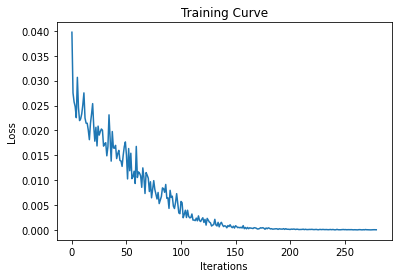

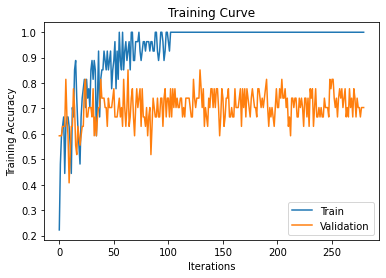

Epoch:  40 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  82.00  % Time Elapsed:  86.18 s 
Epoch 40 Finished.  Time per Epoch:   2.10 s 
Epoch:  41 Train Accuracy:  1.0 Val Accuracy:  0.8518518518518519 Progress:  84.00  % Time Elapsed:  88.30 s 
Epoch 41 Finished.  Time per Epoch:   2.10 s 
SAVED MODEL
Epoch:  42 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  86.00  % Time Elapsed:  90.40 s 
Epoch 42 Finished.  Time per Epoch:   2.10 s 
Epoch:  43 Train Accuracy:  1.0 Val Accuracy:  0.6296296296296297 Progress:  88.00  % Time Elapsed:  92.52 s 
Epoch 43 Finished.  Time per Epoch:   2.10 s 
Epoch:  44 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  90.00  % Time Elapsed:  94.73 s 
Epoch 44 Finished.  Time per Epoch:   2.11 s 
Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  92.00  % Time Elapsed:  96.94 s 
Epoch 45 Finished.  Time per Epoch:   2.11 s 
Epoch:  46 Train Accuracy:  1.0 Val Accuracy:  0.703

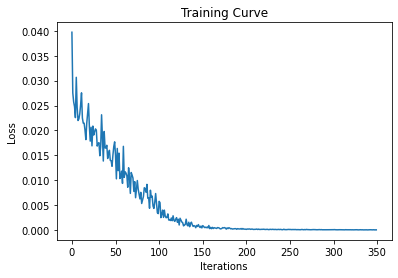

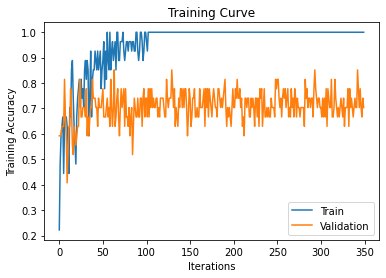

Finished Training
Total time:   105.90 s  Time per Epoch:   2.12 s 


In [30]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Mandarin",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

(27, 3, 128, 192)
128


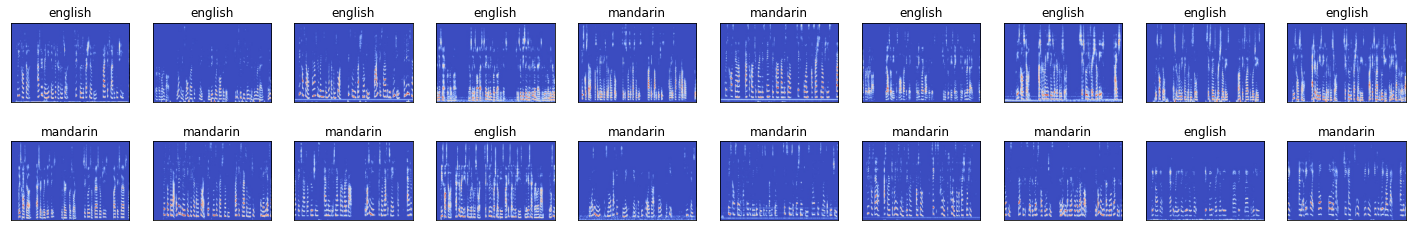

In [6]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI/English_Mandarin_MelSpec_Img"

aug = True

if aug:
    train_set_folders = [
    ]

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"
train_data, val_data, test_data= generate_data_image()
(batch_size, dummy, mfcc_bands, length) = visualize_image_data(train_data, classes)
print(mfcc_bands)

In [14]:
class CRNN2(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN2, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)
        if torch.cuda.is_available():
          h0 = h0.cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.3915343915343915 Val Accuracy:  0.5925925925925926 Progress:   1.00  % Time Elapsed:   2.89 s 
Epoch 0 Finished.  Time per Epoch:   2.89 s 
Epoch:  1 Train Accuracy:  0.5767195767195767 Val Accuracy:  0.6296296296296297 Progress:   2.00  % Time Elapsed:   5.74 s 
Epoch 1 Finished.  Time per Epoch:   2.87 s 
Epoch:  2 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.5925925925925926 Progress:   3.00  % Time Elapsed:   8.58 s 
Epoch 2 Finished.  Time per Epoch:   2.86 s 
Epoch:  3 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5555555555555556 Progress:   4.00  % Time Elapsed:  11.46 s 
Epoch 3 Finished.  Time per Epoch:   2.86 s 
Epoch:  4 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.6296296296296297 Progress:   5.00  % Time Elapsed:  14.45 s 
Epoch 4 Finished.  Time per Epoch:   2.89 s 
Epoch:  5 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5925925925925926 Progress:   6.00  % Time Elapsed:  17.45 s 
Epoch 5 Finished.  T

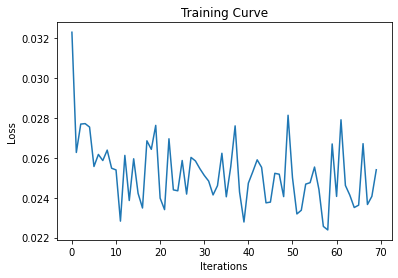

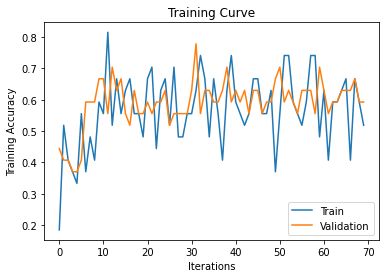

Epoch:  10 Train Accuracy:  0.5873015873015873 Val Accuracy:  0.7037037037037037 Progress:  11.00  % Time Elapsed:  32.25 s 
Epoch 10 Finished.  Time per Epoch:   2.93 s 
Epoch:  11 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5925925925925926 Progress:  12.00  % Time Elapsed:  35.15 s 
Epoch 11 Finished.  Time per Epoch:   2.93 s 
Epoch:  12 Train Accuracy:  0.6666666666666666 Val Accuracy:  0.5925925925925926 Progress:  13.00  % Time Elapsed:  38.05 s 
Epoch 12 Finished.  Time per Epoch:   2.93 s 
Epoch:  13 Train Accuracy:  0.5714285714285714 Val Accuracy:  0.5555555555555556 Progress:  14.00  % Time Elapsed:  40.93 s 
Epoch 13 Finished.  Time per Epoch:   2.92 s 
Epoch:  14 Train Accuracy:  0.7248677248677249 Val Accuracy:  0.7407407407407407 Progress:  15.00  % Time Elapsed:  43.82 s 
Epoch 14 Finished.  Time per Epoch:   2.92 s 
Epoch:  15 Train Accuracy:  0.6825396825396826 Val Accuracy:  0.5555555555555556 Progress:  16.00  % Time Elapsed:  46.72 s 
Epoch 15 Finished.  

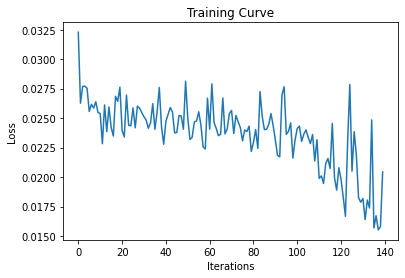

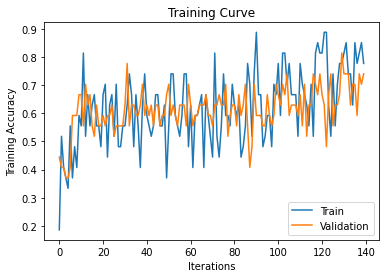

Epoch:  20 Train Accuracy:  0.7037037037037037 Val Accuracy:  0.7037037037037037 Progress:  21.00  % Time Elapsed:  61.64 s 
Epoch 20 Finished.  Time per Epoch:   2.94 s 
Epoch:  21 Train Accuracy:  0.7777777777777778 Val Accuracy:  0.7407407407407407 Progress:  22.00  % Time Elapsed:  64.57 s 
Epoch 21 Finished.  Time per Epoch:   2.94 s 
Epoch:  22 Train Accuracy:  0.7777777777777778 Val Accuracy:  0.7037037037037037 Progress:  23.00  % Time Elapsed:  67.50 s 
Epoch 22 Finished.  Time per Epoch:   2.93 s 
Epoch:  23 Train Accuracy:  0.8201058201058201 Val Accuracy:  0.5925925925925926 Progress:  24.00  % Time Elapsed:  70.39 s 
Epoch 23 Finished.  Time per Epoch:   2.93 s 
Epoch:  24 Train Accuracy:  0.8042328042328042 Val Accuracy:  0.6666666666666666 Progress:  25.00  % Time Elapsed:  73.26 s 
Epoch 24 Finished.  Time per Epoch:   2.93 s 
Epoch:  25 Train Accuracy:  0.8148148148148148 Val Accuracy:  0.4074074074074074 Progress:  26.00  % Time Elapsed:  76.17 s 
Epoch 25 Finished.  

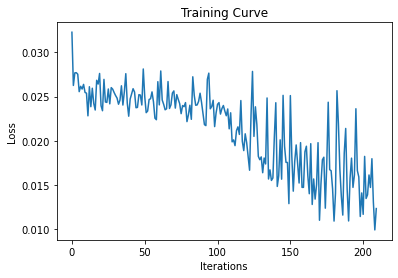

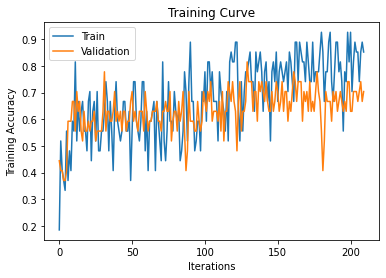

Epoch:  30 Train Accuracy:  0.8306878306878307 Val Accuracy:  0.7777777777777778 Progress:  31.00  % Time Elapsed:  90.99 s 
Epoch 30 Finished.  Time per Epoch:   2.94 s 
Epoch:  31 Train Accuracy:  0.8412698412698413 Val Accuracy:  0.7037037037037037 Progress:  32.00  % Time Elapsed:  93.91 s 
Epoch 31 Finished.  Time per Epoch:   2.93 s 
Epoch:  32 Train Accuracy:  0.8465608465608465 Val Accuracy:  0.7407407407407407 Progress:  33.00  % Time Elapsed:  96.85 s 
Epoch 32 Finished.  Time per Epoch:   2.93 s 
Epoch:  33 Train Accuracy:  0.8677248677248677 Val Accuracy:  0.6296296296296297 Progress:  34.00  % Time Elapsed:  99.76 s 
Epoch 33 Finished.  Time per Epoch:   2.93 s 
Epoch:  34 Train Accuracy:  0.8624338624338624 Val Accuracy:  0.6666666666666666 Progress:  35.00  % Time Elapsed:  102.71 s 
Epoch 34 Finished.  Time per Epoch:   2.93 s 
Epoch:  35 Train Accuracy:  0.9047619047619048 Val Accuracy:  0.7407407407407407 Progress:  36.00  % Time Elapsed:  105.65 s 
Epoch 35 Finished.

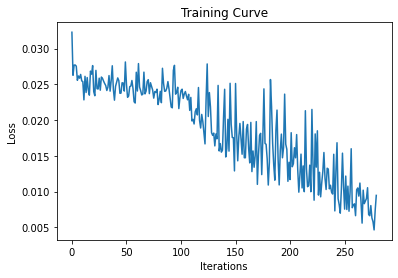

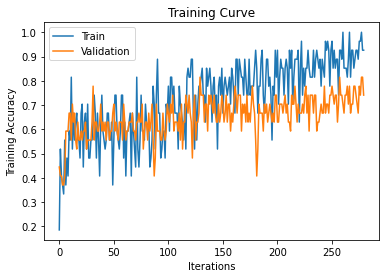

Epoch:  40 Train Accuracy:  0.9153439153439153 Val Accuracy:  0.7037037037037037 Progress:  41.00  % Time Elapsed:  120.75 s 
Epoch 40 Finished.  Time per Epoch:   2.95 s 
Epoch:  41 Train Accuracy:  0.9365079365079365 Val Accuracy:  0.8148148148148148 Progress:  42.00  % Time Elapsed:  123.73 s 
Epoch 41 Finished.  Time per Epoch:   2.95 s 
SAVED MODEL
Epoch:  42 Train Accuracy:  0.91005291005291 Val Accuracy:  0.7037037037037037 Progress:  43.00  % Time Elapsed:  126.71 s 
Epoch 42 Finished.  Time per Epoch:   2.95 s 
Epoch:  43 Train Accuracy:  0.9206349206349206 Val Accuracy:  0.7777777777777778 Progress:  44.00  % Time Elapsed:  129.69 s 
Epoch 43 Finished.  Time per Epoch:   2.95 s 
Epoch:  44 Train Accuracy:  0.9523809523809523 Val Accuracy:  0.7407407407407407 Progress:  45.00  % Time Elapsed:  132.68 s 
Epoch 44 Finished.  Time per Epoch:   2.95 s 
Epoch:  45 Train Accuracy:  0.9841269841269841 Val Accuracy:  0.7777777777777778 Progress:  46.00  % Time Elapsed:  135.66 s 
Epoc

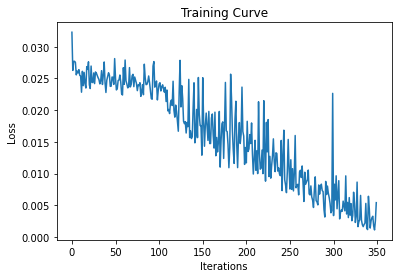

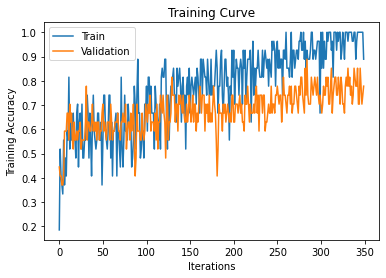

Epoch:  50 Train Accuracy:  0.9682539682539683 Val Accuracy:  0.8148148148148148 Progress:  51.00  % Time Elapsed:  150.83 s 
Epoch 50 Finished.  Time per Epoch:   2.96 s 
Epoch:  51 Train Accuracy:  0.9947089947089947 Val Accuracy:  0.7777777777777778 Progress:  52.00  % Time Elapsed:  153.83 s 
Epoch 51 Finished.  Time per Epoch:   2.96 s 
Epoch:  52 Train Accuracy:  0.9947089947089947 Val Accuracy:  0.8148148148148148 Progress:  53.00  % Time Elapsed:  156.84 s 
Epoch 52 Finished.  Time per Epoch:   2.96 s 
Epoch:  53 Train Accuracy:  0.9894179894179894 Val Accuracy:  0.8148148148148148 Progress:  54.00  % Time Elapsed:  159.83 s 
Epoch 53 Finished.  Time per Epoch:   2.96 s 
Epoch:  54 Train Accuracy:  1.0 Val Accuracy:  0.8888888888888888 Progress:  55.00  % Time Elapsed:  162.85 s 
Epoch 54 Finished.  Time per Epoch:   2.96 s 
SAVED MODEL
Epoch:  55 Train Accuracy:  0.9947089947089947 Val Accuracy:  0.7777777777777778 Progress:  56.00  % Time Elapsed:  165.85 s 
Epoch 55 Finished

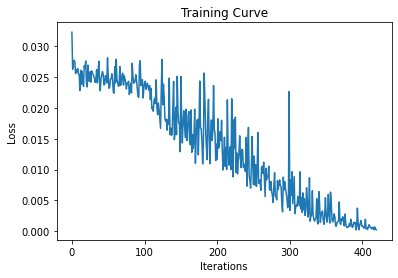

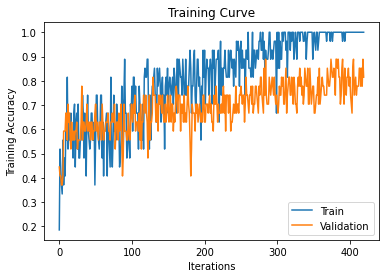

Epoch:  60 Train Accuracy:  1.0 Val Accuracy:  0.8518518518518519 Progress:  61.00  % Time Elapsed:  181.18 s 
Epoch 60 Finished.  Time per Epoch:   2.97 s 
Epoch:  61 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  62.00  % Time Elapsed:  184.22 s 
Epoch 61 Finished.  Time per Epoch:   2.97 s 
Epoch:  62 Train Accuracy:  1.0 Val Accuracy:  0.9259259259259259 Progress:  63.00  % Time Elapsed:  187.27 s 
Epoch 62 Finished.  Time per Epoch:   2.97 s 
SAVED MODEL
Epoch:  63 Train Accuracy:  1.0 Val Accuracy:  0.8888888888888888 Progress:  64.00  % Time Elapsed:  190.33 s 
Epoch 63 Finished.  Time per Epoch:   2.97 s 
Epoch:  64 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  65.00  % Time Elapsed:  193.36 s 
Epoch 64 Finished.  Time per Epoch:   2.97 s 
Epoch:  65 Train Accuracy:  1.0 Val Accuracy:  0.8148148148148148 Progress:  66.00  % Time Elapsed:  196.38 s 
Epoch 65 Finished.  Time per Epoch:   2.98 s 
Epoch:  66 Train Accuracy:  1.0 Val Accuracy: 

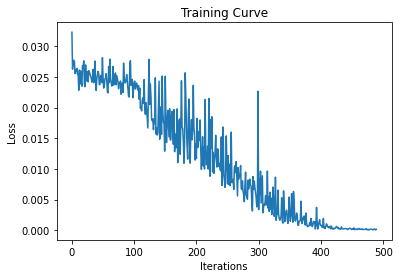

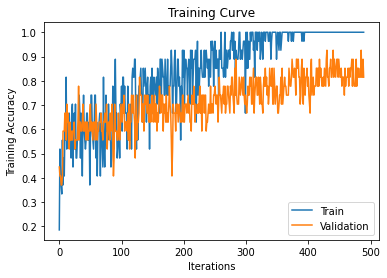

Epoch:  70 Train Accuracy:  1.0 Val Accuracy:  0.8518518518518519 Progress:  71.00  % Time Elapsed:  211.88 s 
Epoch 70 Finished.  Time per Epoch:   2.98 s 
Epoch:  71 Train Accuracy:  1.0 Val Accuracy:  0.8148148148148148 Progress:  72.00  % Time Elapsed:  214.95 s 
Epoch 71 Finished.  Time per Epoch:   2.99 s 
Epoch:  72 Train Accuracy:  1.0 Val Accuracy:  0.8888888888888888 Progress:  73.00  % Time Elapsed:  218.02 s 
Epoch 72 Finished.  Time per Epoch:   2.99 s 
Epoch:  73 Train Accuracy:  1.0 Val Accuracy:  0.8888888888888888 Progress:  74.00  % Time Elapsed:  221.10 s 
Epoch 73 Finished.  Time per Epoch:   2.99 s 
Epoch:  74 Train Accuracy:  1.0 Val Accuracy:  0.8518518518518519 Progress:  75.00  % Time Elapsed:  224.21 s 
Epoch 74 Finished.  Time per Epoch:   2.99 s 
Epoch:  75 Train Accuracy:  1.0 Val Accuracy:  0.8518518518518519 Progress:  76.00  % Time Elapsed:  227.36 s 
Epoch 75 Finished.  Time per Epoch:   2.99 s 
Epoch:  76 Train Accuracy:  1.0 Val Accuracy:  0.851851851

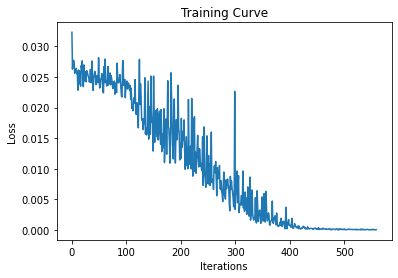

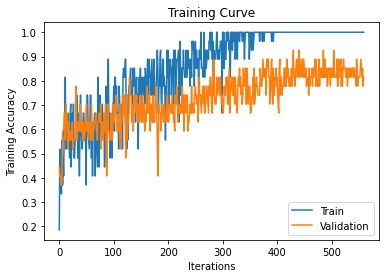

Epoch:  80 Train Accuracy:  1.0 Val Accuracy:  0.8148148148148148 Progress:  81.00  % Time Elapsed:  243.25 s 
Epoch 80 Finished.  Time per Epoch:   3.00 s 
Epoch:  81 Train Accuracy:  1.0 Val Accuracy:  0.8888888888888888 Progress:  82.00  % Time Elapsed:  246.43 s 
Epoch 81 Finished.  Time per Epoch:   3.01 s 
Epoch:  82 Train Accuracy:  1.0 Val Accuracy:  0.8888888888888888 Progress:  83.00  % Time Elapsed:  249.63 s 
Epoch 82 Finished.  Time per Epoch:   3.01 s 
Epoch:  83 Train Accuracy:  1.0 Val Accuracy:  0.8148148148148148 Progress:  84.00  % Time Elapsed:  252.79 s 
Epoch 83 Finished.  Time per Epoch:   3.01 s 
Epoch:  84 Train Accuracy:  1.0 Val Accuracy:  0.8518518518518519 Progress:  85.00  % Time Elapsed:  255.95 s 
Epoch 84 Finished.  Time per Epoch:   3.01 s 
Epoch:  85 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  86.00  % Time Elapsed:  259.15 s 
Epoch 85 Finished.  Time per Epoch:   3.01 s 
Epoch:  86 Train Accuracy:  1.0 Val Accuracy:  0.851851851

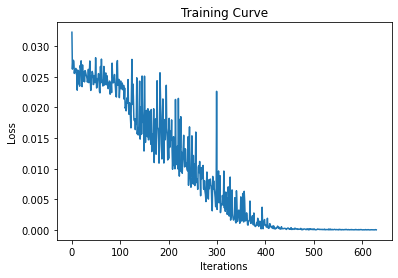

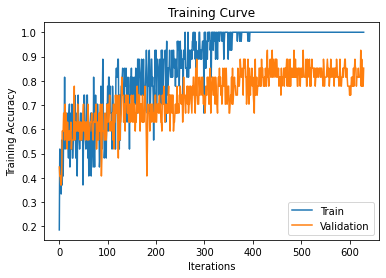

Epoch:  90 Train Accuracy:  1.0 Val Accuracy:  0.8518518518518519 Progress:  91.00  % Time Elapsed:  276.21 s 
Epoch 90 Finished.  Time per Epoch:   3.04 s 
Epoch:  91 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  92.00  % Time Elapsed:  280.23 s 
Epoch 91 Finished.  Time per Epoch:   3.05 s 
Epoch:  92 Train Accuracy:  1.0 Val Accuracy:  0.8888888888888888 Progress:  93.00  % Time Elapsed:  284.22 s 
Epoch 92 Finished.  Time per Epoch:   3.06 s 
Epoch:  93 Train Accuracy:  1.0 Val Accuracy:  0.8518518518518519 Progress:  94.00  % Time Elapsed:  288.24 s 
Epoch 93 Finished.  Time per Epoch:   3.07 s 
Epoch:  94 Train Accuracy:  1.0 Val Accuracy:  0.8888888888888888 Progress:  95.00  % Time Elapsed:  292.20 s 
Epoch 94 Finished.  Time per Epoch:   3.08 s 
Epoch:  95 Train Accuracy:  1.0 Val Accuracy:  0.8148148148148148 Progress:  96.00  % Time Elapsed:  296.17 s 
Epoch 95 Finished.  Time per Epoch:   3.09 s 
Epoch:  96 Train Accuracy:  1.0 Val Accuracy:  0.851851851

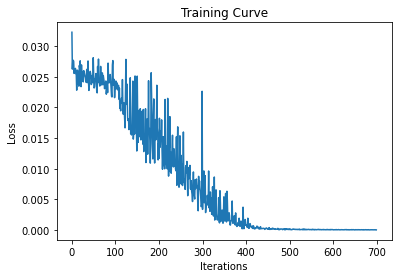

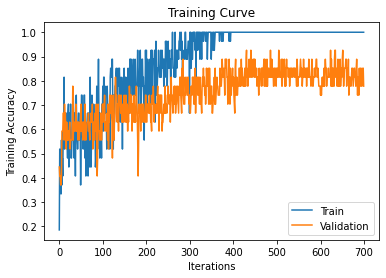

Finished Training
Total time:   312.78 s  Time per Epoch:   3.13 s 


In [45]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 100
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Mandarin_MelSpec_Img",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN2(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

In [24]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 100
learning_rate = 0.0005
num_workers = 1
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "English_Mandarin_MelSpec_Img",
    "num_classes": 2,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
net = CRNN2(config)

model_path =  "/content/drive/My Drive/APS360 Group Project/model_checkpoints/model_English_Mandarin_MelSpec_Img_bs27_lr0.0005_epoch63/model_English_Mandarin_MelSpec_Img_bs27_lr0.0005_epoch63"
state = torch.load(model_path, map_location=torch.device('cpu'))
net.load_state_dict(state)

if torch.cuda.is_available():
  net = net.cuda()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
test_acc = get_accuracy_cnn(net, test_loader)

print("Test accuracy is: " + str(test_acc))

Test accuracy is: 0.8518518518518519
